In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle
import glob
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
import os

%load_ext autoreload
%autoreload 2

In [2]:
sns.set_context('poster')

# from gn4pions.modules import plot_util as pu
# from gn4pions.modules import resolution_util as ru
# import atlas_mpl_style as ampl
# ampl.set_color_cycle('Oceanic',10)
# plt.style.use('paper')
# sns.set_style('white')

In [3]:
path_prefix = '../scripts/graph_approaches/'
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
import atlas_mpl_style as ampl
ampl.set_color_cycle('Oceanic',10)
# plt.style.use('paper')

In [4]:
data_dirs = ['./results/onetrack_multicluster/Block_mae_20220516_1858_track_regress_noCell/',
             './results/onetrack_multicluster/Block_20220527_1627_trackCalo_regress/',
             './results/onetrack_multicluster/Block_mae_20220516_1900_track_regress_noCell_nClusters/',
             './results/onetrack_multicluster/Block_20220602_2236_trackMultiCalo_regress/']

labels = ['FullGNN Leading Cluster', 'Leading Cluster with Cells',
          'FullGNN All Clusters', 'All Clusters with Cells']

Loading form ./results/onetrack_multicluster/Block_mae_20220516_1858_track_regress_noCell/
Loading form ./results/onetrack_multicluster/Block_20220527_1627_trackCalo_regress/
Loading form ./results/onetrack_multicluster/Block_mae_20220516_1900_track_regress_noCell_nClusters/
Loading form ./results/onetrack_multicluster/Block_20220602_2236_trackMultiCalo_regress/


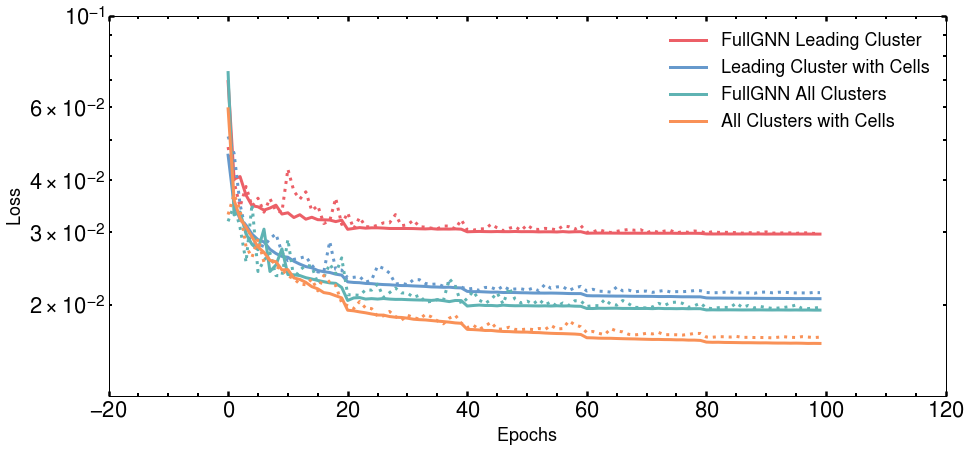

In [5]:
pion_list = ['pion']
sym_list = ['+-',]
concat_type = ['False']
model_name = ['ConcatFalse']
line = ['-', '--', ':', '-.']
blues = matplotlib.cm.Blues_r(np.linspace(0,1,20))
oranges = matplotlib.cm.Oranges_r(np.linspace(0,1,20))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(15,7))
for i in range(4):
    hist_files = np.sort(glob.glob(data_dirs[i] + 'losses.npz'))
    print('Loading form {}'.format(data_dirs[i]))
    hist = np.load(hist_files[0])
    plt.semilogy(hist['training'].mean(axis=1), color=colors[i+1], 
                 label=labels[i], linestyle=line[0])
    plt.semilogy(hist['validation'].mean(axis=1), color=colors[i+1], 
                 label=None, linestyle=line[2])


plt.ylabel(r'$Loss$')
plt.xlabel(r'$Epochs$')
plt.ylim([1.2e-2, 1e-1])
# sns.despine()
plt.legend()
    # plt.savefig('results/training_mse.png', bbox_inches='tight', dpi=300)
plt.show()


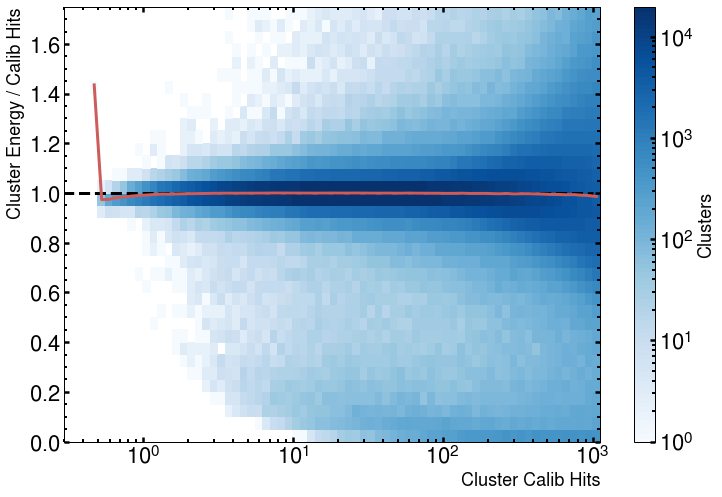

<Figure size 799.992x599.976 with 0 Axes>

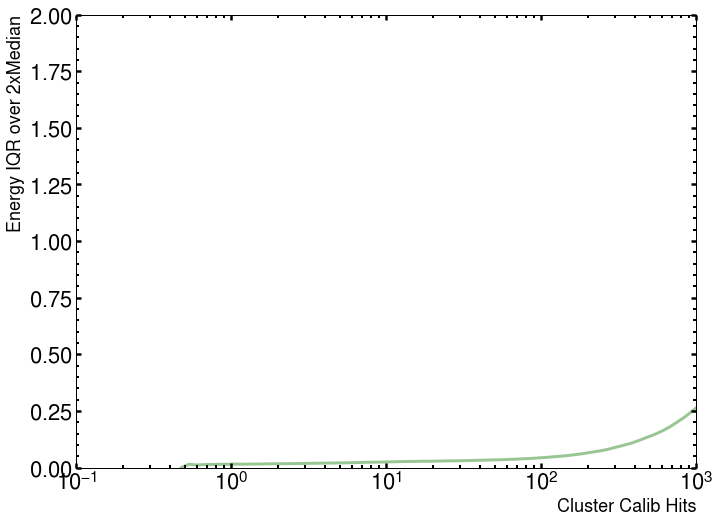

In [18]:
df = pd.read_pickle(data_dirs[3]+'track_meta_df_inference.pkl')
gt_true = df.truthPartE # test.loc[np.abs(test.track_eta)<1, 'truth_particle_e']
pred = df.trackPt*np.cosh(df.trackEta)
gt_ratio = (pred)/(gt_true)

_, gt_resp = ru.responsePlot(gt_true, gt_ratio,
                             statistic = 'median',
                             make_plot=True
                            )
_, gt_iqr = ru.resolutionPlot(gt_true, gt_ratio, statistic='iqrOverMed')

In [7]:
df.describe()

,trackPt,trackD0,trackZ0,trackEta_EMB2,trackPhi_EMB2,trackEta,trackPhi,truthPartE,truthPartPt,num_clusters
count,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06,2.503599e+06
mean,1.979549e+02,-7.465684e-04,-7.436059e-03,-3.587788e+08,-3.587788e+08,1.195790e-03,2.112684e-03,3.252980e+02,1.849686e+02,2.452424e+00
std,3.933964e+02,6.631870e-01,4.255733e+01,4.796422e+08,4.796422e+08,1.364588e+00,1.813226e+00,4.662433e+02,3.070053e+02,2.051281e+00
min,5.000029e-01,-9.244496e+01,-2.497741e+02,-1.000000e+09,-1.000000e+09,-2.499999e+00,-3.141592e+00,4.962928e-01,1.554056e-01,1.000000e+00
25%,9.727914e+00,-1.066693e-02,-2.842495e+01,-1.000000e+09,-1.000000e+09,-1.119207e+00,-1.568682e+00,2.030186e+01,1.024768e+01,1.000000e+00
50%,4.544316e+01,6.549128e-04,8.754432e-03,-7.920683e-01,-1.755710e+00,1.868324e-03,2.664972e-03,9.587964e+01,4.782394e+01,2.000000e+00
75%,2.079718e+02,1.199876e-02,2.838329e+01,3.109168e-01,6.921763e-01,1.122945e+00,1.572610e+00,4.351783e+02,2.155107e+02,3.000000e+00
max,4.999725e+03,8.795609e+01,2.498972e+02,1.759320e+00,3.141588e+00,2.499995e+00,3.141588e+00,1.999997e+03,1.999661e+03,3.700000e+01


In [8]:
response_median_pions = []
for i in range(4):
    print(data_dirs[i])
    resp = np.load(data_dirs[i]+'/response_medians.npz')['response_median']
    response_median_pions.append(resp[0])

response_median_pions.append(gt_resp)

response_median_pions = np.vstack(response_median_pions)
xcenter = np.load(data_dirs[1]+'/response_medians.npz')['xcenter']

./results/onetrack_multicluster/Block_mae_20220516_1858_track_regress_noCell/
./results/onetrack_multicluster/Block_20220527_1627_trackCalo_regress/
./results/onetrack_multicluster/Block_mae_20220516_1900_track_regress_noCell_nClusters/
./results/onetrack_multicluster/Block_20220602_2236_trackMultiCalo_regress/


extra_line [[0, 10000.0], [1, 1]]


<Figure size 799.992x599.976 with 0 Axes>

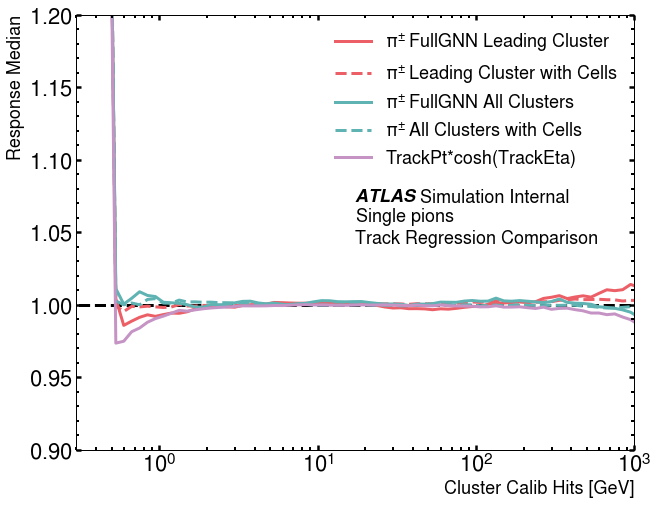

In [17]:
line_labels = [r'$\pi^{\pm}\:$'+labels[i] for i in range(4)]
line_labels.append('TrackPt*cosh(TrackEta)')

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

pu.lineOverlay(xcenter=xcenter, lines=response_median_pions,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = line_labels,
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response Median',
                figfile = '', # medResponse_gnBlock.png',
                y_max=1.2, y_min=.9, x_min = .3,
                extra_lines= [[[0, 10e3], [1, 1]]],
                linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid'],
                colors = [colors[1], colors[1], colors[3], colors[3], colors[5]],
                atlas_x = 0.5, atlas_y = 0.60, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.525, 'text': 'Single $pions$'},
                            {'x': 0.5, 'y': 0.475,  'text': 'Track Regression Comparison'}])

In [10]:
iqr_pions = []
for i in range(4):
    print(data_dirs[i])
    iqr = np.load(data_dirs[i]+'/iqr.npz')['response_median']
    iqr_pions.append(iqr[0])


plt.close()
iqr_pions.append(gt_iqr)

iqr_pions = np.vstack(iqr_pions)
xcenter = np.load(data_dirs[1]+'/iqr.npz')['xcenter']

./results/onetrack_multicluster/Block_mae_20220516_1858_track_regress_noCell/
./results/onetrack_multicluster/Block_20220527_1627_trackCalo_regress/
./results/onetrack_multicluster/Block_mae_20220516_1900_track_regress_noCell_nClusters/
./results/onetrack_multicluster/Block_20220602_2236_trackMultiCalo_regress/


<Figure size 799.992x599.976 with 0 Axes>

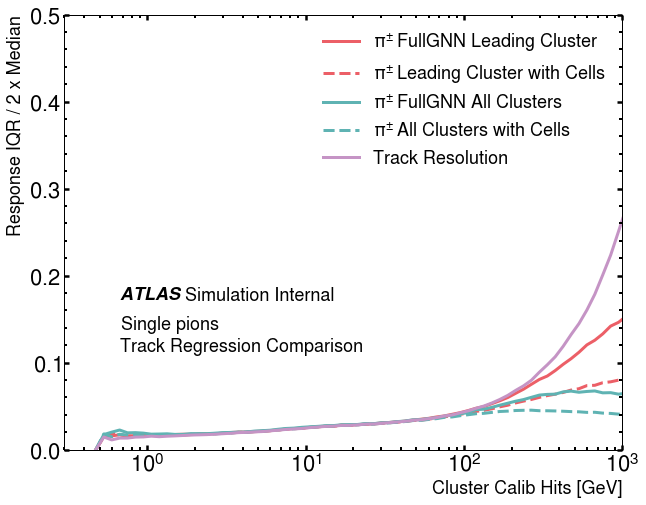

In [11]:
line_labels = [r'$\pi^{\pm}\:$'+labels[i] for i in range(4)]
line_labels.append('Track Resolution')
pu.lineOverlay(xcenter=xcenter, lines = iqr_pions,  # [iqrOverMedpi0, iqrOverMedpiplus, iqrOverMedpiminus],
                labels = line_labels,
                xlabel = 'Cluster Calib Hits [GeV]', ylabel = 'Response IQR / 2 x Median',
                figfile = '', # 'iqr_gnBlock.png',
                y_max = .5, x_min = .3,
                linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid'],
                colors = [colors[1], colors[1], colors[3], colors[3], colors[5]],
                atlas_x = 0.1, atlas_y = 0.375, simulation = True,
                textlist = [{'x': 0.1, 'y': 0.275, 'text': 'Single $pions$'},
                            {'x': 0.1, 'y': 0.225,  'text': 'Track Regression Comparison'}])

In [12]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [13]:
colors

['on:green',
 'on:red',
 'on:blue',
 'on:cyan',
 'on:orange',
 'on:pink',
 'on:yellow']